# Final Tutorial: Analysis of Esports Earnings Across Different Games

Kevin Liang, Kevin Lopoi, Jordan Marry

## Introduction: eSports 

Over the last decade, the the gaming industry has become more and more popular. This large influx in popularity resulted in a boom in the competitve gaming scene, known as eSports. eSports is defined as a form of organized sport competition which involves video games, and is typically between professional players in an individual or a team setting.

While compeitions have always been popular in gaming culture, there wasn't particularly a "professional scene" for video games. Until the late 2000s, competitions have been mostly among amateurs. As more and more people began playing video games and video games become more popularized in our everyday life, viewers for tournaments and video game content in general began increasing as well. However, by the 2010s, eSports have become a "signficiant factor" in the video game industry as companies began to follow a "franchise approach" used in North American sports where there are financial sponsors looking to support teams.

Even to this day, eSports viewership has continued to increase as monthly eSports viewers have increased by 11.4% from 2020. The integration to popular culture and utilization of media outlets all contribute to this growth, and eSports organizations have produced many competitive organizers not only filled with players, but also influencers.
From 2017 to 2018, investments in the industry have skyrocketed from \\$490 million all the way to \\$4.5 billion. These investments are distributed across teams and players across many different games. Projections for this year has the industry on track to "surpass 1 billion dollars in revenue and hit 1.8 billion by 2022 according to Newzoo.
Read more about the growing revenue stream here: 
https://www.insiderintelligence.com/insights/esports-ecosystem-market-report/
This large amount of money does include sponsorships, advertisements, on top of tournament earnings itself. 

This dataset will look at tournament earnings alone, across 10 of the most popular games in the past decade:
Dota2, Counter-Strike: Global Offensive, Fortnite, League of Legends, Starcraft II, Overwatch, PUBG, Hearthstone, Heroes of the Storm, Arena of Valor

If you are curious and want to know more about the eSports industry, you can find out more at: 
https://en.wikipedia.org/wiki/Esports

## Purpose

This tutorial will involve utilizing techniques utilized in data science to analyze a data set that was scraped off https://www.esportsearnings.com, a website that tracks earnings by teams, organizations, and players across all the competitive games. We will be focusing on players and their earnings throughout the years and analyze the results to hope to see trends in how much players earned throughout the years. 

In [213]:
import pandas as pd
import re
import numpy as np
import requests
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup

## Scraping Data

We are scraping data from the website https://www.esportsearnings.com. This is done through using BeautifulSoup4 (BS4). We are going to be looking at the top 100 top-earning players from years 2010 to 2021. This information was obtained through the https://www.esportsearnings.com/history/ "year" /top_plyaers. Using BS4, we obtain the html of the website, we then find the table of the top 100 top-earnings players. Using the table, we got the player's name, rank for that year, in-game name, total amount for the year, total amount overall. We wanted a little bit more informationa bout the players. In the table, there were hyperlinks that allowed us to look at their player profile, which included country of origin, current game they are playing, and number of tournaments they have been in.

In [35]:
years = ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]
dfs = []


session = requests.Session()
retry = Retry(connect=10, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

In [4]:
# Grabbing all the top 100 players from 2010-2021
for i in years:
    # players
    url = "https://www.esportsearnings.com/history/" + i + "/top_players"
    page = session.get(url)
    root = BeautifulSoup(page.content)
    root.prettify()
    table = root.find("table")
    
    rows = table.findAll('tr')
    headers = rows[0].findAll('td')
    headers = headers[1:]
    cols = []
    for head in headers:
        cols.append(head.text.strip())
    
    cols.insert(0, "Rank")
    cols.insert(1, "Year")
    cols.insert(2, "Country")
    cols[3] = "In-Game Name"
    cols.append("Game")
    cols.append("# of Tournaments")
    cols.remove("% of Total")
    
    players = rows[1:]
    
    rank = []
    country = []
    ign = []
    player_name = []
    total_year = []
    total_overall = []
    games = []
    tournaments = []
    
    for player in players:
        infos = player.findAll('td')
        rank.append(infos[0].text.strip())
        country.append(infos[1].find('img').get('title'))
        ign.append(infos[1].text.strip())
        player_name.append(infos[2].text.strip())
        total_year.append(infos[3].text.strip())
        total_overall.append(infos[4].text.strip())
        links = infos[1].findAll('a')
        url2 = "https://www.esportsearnings.com/" + links[1].get('href')
        page = session.get(url2)
        root = BeautifulSoup(page.content)
        title = root.find("h1")
        title = title.text.strip()
        games.append(title)
                
        tourney = root.find_all(text=re.compile(' From ' + r'[0-9]+' + ' Tournament'))
        stri = tourney[0].split()
        tournaments.append(stri[1])
        
        
        
    
    df = pd.DataFrame(columns = cols)
    df['Rank'] = rank
    df['Year'] = i
    df['Country'] = country
    df['In-Game Name'] = ign
    df['Player Name'] = player_name
    df['Total (Year)'] = total_year
    df['Total (Overall)'] = total_overall
    df['Game'] = games
    df['# of Tournaments'] = tournaments
    
    dfs.append(df)
    
df = pd.concat(dfs)

# Commenting out so data isn't written over
# df.to_csv('players.csv')

In [122]:
df = pd.read_csv('players.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [123]:
games = df['Game'].str.split("- ")
df['Game'] = games

In [124]:
df = df.astype({"Rank": int})

In [125]:
for i in range(0,len(df)):
    df.at[i,'Game'] = df.loc[:, "Game"][i][-1]

In [126]:
df['Game'] = df['Game'].str.replace(" Player","")
df = df.rename(columns={"In-Game Name": "IGN", "Total (Year)": "Total_Year", "Total (Overall)" : "Total_Overall", "# of Tournaments" : "Num_Tournaments"})
df

,Rank,Year,Country,IGN,Player Name,Total_Year,Total_Overall,Game,Num_Tournaments
0,1,2010,"Korea, Republic of",Flash,"Lee, Young Ho","$194,924.30","$670,457.77",StarCraft: Brood War,97
1,2,2010,United States,Mystik,Katherine Gunn,"$100,000.00","$122,550.00",Female Call of Duty,7
2,3,2010,United States,applesauce,Mark Smith,"$100,000.00","$100,000.00",Multigaming,1
3,4,2010,"Korea, Republic of",Jaedong,"Lee, Jae Dong","$98,019.82","$643,290.35",StarCraft: Brood War,111
4,5,2010,"Korea, Republic of",FruitDealer,"Kim, Won Ki","$92,393.59","$103,075.12",StarCraft II,13
...,...,...,...,...,...,...,...,...,...
1195,96,2021,China,coolboy,"Zeng, Ronghua","$213,286.23","$440,728.58",PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,9
1196,97,2021,"Taiwan, Republic of China",Jimmy,"Xu, Yinjun","$213,286.23","$440,728.58",PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,9
1197,98,2021,"Taiwan, Republic of China",King,"Lin, Yien","$213,286.23","$383,202.47",PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,6
1198,99,2021,Israel,Fly,Tal Aizik,"$211,680.00","$2,610,250.81",Dota 2,123


## Explanatory Data Analysis

We have our data that we scraped and put into the dataframe. Now we have to do some digging and play around with it in order to get a better understanding of our data. This is known as Exploratory Data Analysis, which is known as the process of performing initial investigations on the data we have in order to look for patterns, gather insights, and test our hypotheses if we have any.

We have our dataframe and it is cleaned. It currently contains around 1200 entries of top 100 earning competitive players across the years 2010 to 2021. Currently we have columns as Rank, Year, Country, In-Game Name, Player Name, Total(Year), Total(Overall), Game, and # of Tournaments. 

Out of curiousity lets take a look at the top earning players in the past decade. We can use sort values with the column that we are interested in sorting by. We will call this top_Earners.


In [127]:
top_Earners = df.sort_values(by="Total_Overall", ascending=False, ignore_index = True)
#Only use the columns we care about. We can also use top_Earners.drop to achieve similar results
top_Earners = top_Earners[["Player Name", "IGN", "Total_Overall", "Game"]].head(10)
top_Earners

,Player Name,IGN,Total_Overall,Game
0,Hayden Krueger,Elevate,"$993,523.20",VALORANT
1,Jacky Mao,EternaLEnVy,"$992,222.69",Dota 2
2,Jacky Mao,EternaLEnVy,"$992,222.69",Dota 2
3,Jacky Mao,EternaLEnVy,"$992,222.69",Dota 2
4,"Du, Peng",Monet,"$991,422.61",Dota 2
5,Mike Peterson,Wickd,"$99,208.88",League of Legends
6,Johan Åström,pieliedie,"$989,390.86",Dota 2
7,Johan Åström,pieliedie,"$989,390.86",Dota 2
8,Johan Åström,pieliedie,"$989,390.86",Dota 2
9,Kuku Palad,KuKU,"$982,344.63",Dota 2


Above, we can see how the the top earning players. 
### Wait ... this doesn't seem right.
The problem was that the Total (Overall) column is not a float, our numbers are sorted, but not sorted by the value itself. $993,000 might seem like quite a bit, but its no where near the top earners. 
Therefore, lets change that in our original data frame and then rerun the same code. 

In [128]:
#We have to replace some characters in the string in order to be able to convert it to a float.
df['Total_Year'] = df['Total_Year'].str.replace("$","")
df['Total_Year'] = df['Total_Year'].str.replace(",","")
df['Total_Overall'] = df['Total_Overall'].str.replace("$","")
df['Total_Overall'] = df['Total_Overall'].str.replace(",","")
#Converting the column values to all floats
df['Total_Year'] = df['Total_Year'].astype(float)
df['Total_Overall'] = df['Total_Overall'].astype(float)

#Now we can run that same code again and see the results

top_Earners = df.sort_values(by="Total_Overall", ascending=False, ignore_index = True)
#Only use the columns we care about. We can also use top_Earners.drop to achieve similar results
top_Earners = top_Earners[["Player Name", "IGN", "Total_Overall", "Game"]]
top_Earners = top_Earners.drop_duplicates('Player Name')
top_Earners.head()

C:\Users\Jordan\AppData\Local\Temp/ipykernel_14008/1533425610.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Total_Year'] = df['Total_Year'].str.replace("$","")
C:\Users\Jordan\AppData\Local\Temp/ipykernel_14008/1533425610.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Total_Overall'] = df['Total_Overall'].str.replace("$","")


,Player Name,IGN,Total_Overall,Game
0,Johan Sundstein,N0tail,7183917.80,Dota 2
7,Jesse Vainikka,JerAx,6470548.78,VALORANT
11,Anathan Pham,ana,6004411.96,Dota 2
15,Sébastien Debs,Ceb,5773812.41,Dota 2
18,Topias Taavitsainen,Topson,5690417.57,Dota 2



That looks much better. We also had to remove the duplicates based on name, since this dataset includes entries from the years 2010 to 2021. From this we can clearly see that out of our entries, the top earning players earned way more than 1 million total in their competitive gaming career from tournaments.

It seems that 4 of the top 5 players were all Dota 2 players with the second place earner is a Valorant player. This could be due to the longevity of the game as other games such as League of Legends and Valorant are much newer. Lets take a look at the overall earnings for each game.

While it seems that Dota 2 may produce the top earning players, lets compare the earnings from each game to see what type of game is the most earning at the moment.

In [129]:
games = top_Earners.groupby('Game').sum().sort_values(by = "Total_Overall", ascending = False)
print(games.round())

                                      Total_Overall
Game                                               
Dota 2                                  234029223.0
CS:GO                                    53386996.0
League of Legends                        29773296.0
Fortnite                                 26772052.0
Call of Duty                             25358285.0
StarCraft II                             17619117.0
Arena of Valor                           14156671.0
VALORANT                                 13963580.0
PUBG                                      6914846.0
Halo                                      4893454.0
StarCraft: Brood War                      4081867.0
Fighting Game                             3843965.0
PLAYERUNKNOWN'S BATTLEGROUNDS Mobile      3757826.0
Hearthstone                               3365449.0
Rainbow Six Siege                         3331810.0
Overwatch                                 3206911.0
WarCraft III: Reforged                    2412203.0
SMITE       

From printing out the total earnings from players across games we now have a better idea of how much games have made.
#### To visualize this better, lets graph this. 
Visualizing data is a big part of exploratory data analysis. Therefore lets make a graph to see the top earning games. We can also extend this further to see the trends in games across the years, by graphing the earnings of each game by year. 
The first graph shows the top earnings from 2010 - 2021, with salaries from every player, every year all combined together grouped by games. The Y axis will show earnings in millions. 

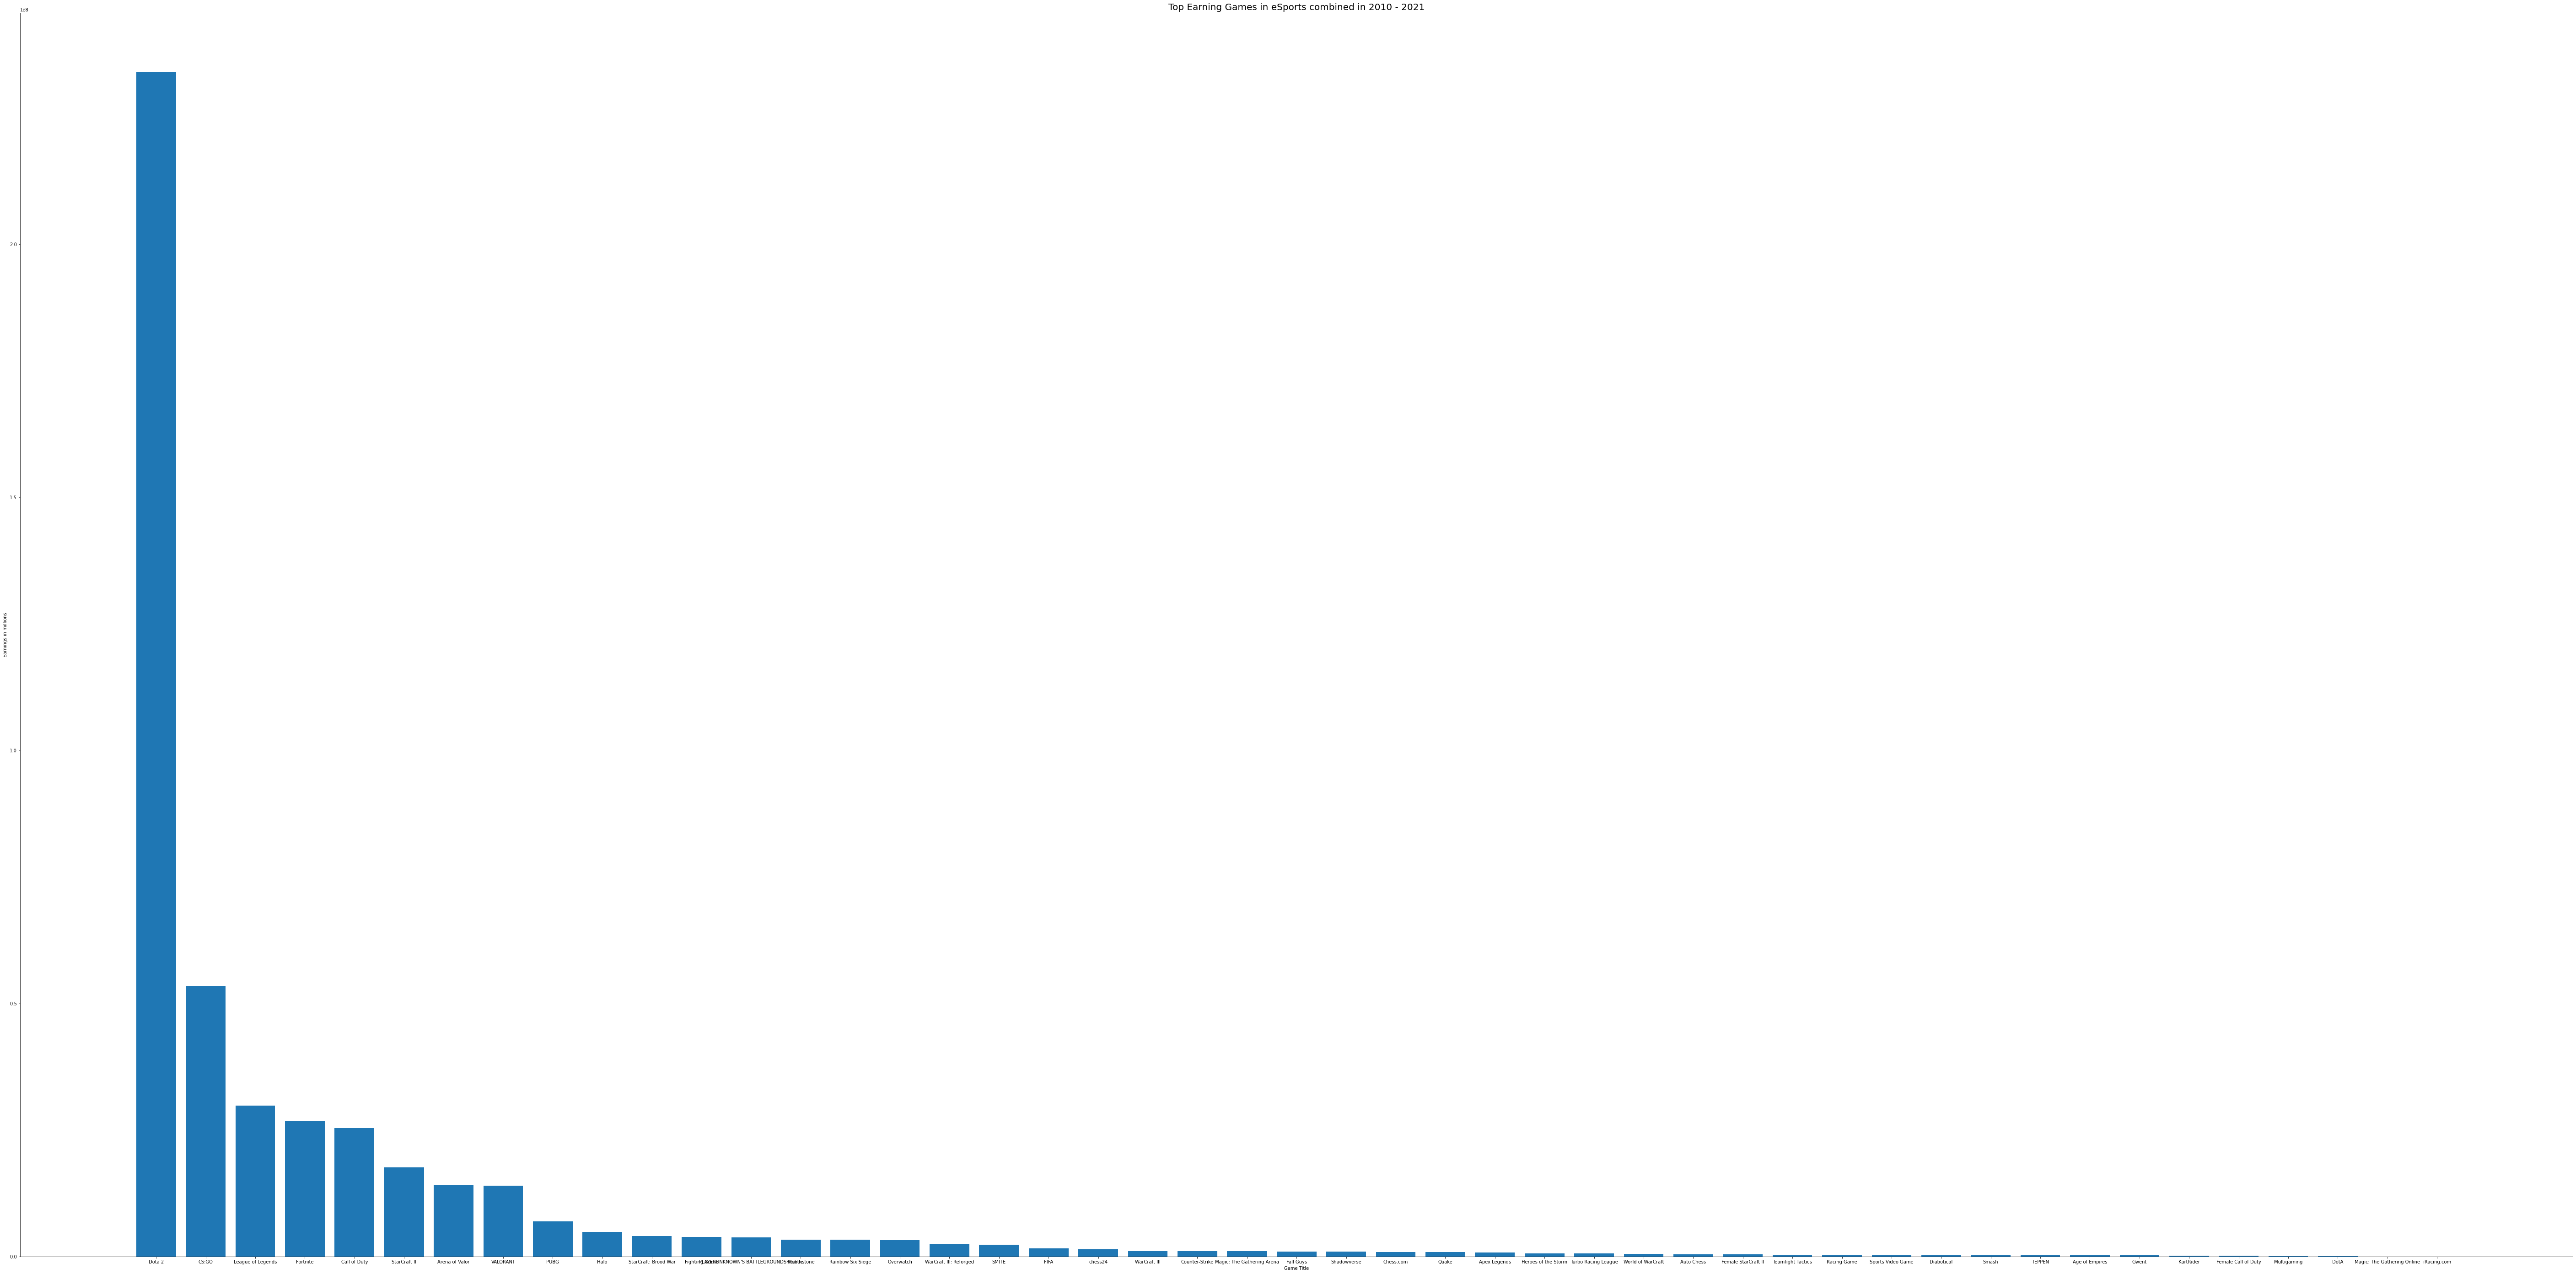

In [130]:
#we are gonna need this import
import matplotlib.pyplot as plt

plt.figure(figsize = (100,50))
plt.title("Top Earning Games in eSports combined in 2010 - 2021")
plt.xlabel("Game Title")
plt.ylabel("Earnings in millions")
plt.bar(games.index, games['Total_Overall'])

plt.rc('axes', titlesize=20)
plt.show()

In [131]:
game_titles = np.unique(df['Game'])
years = np.arange(2010,2022)
years_table = pd.DataFrame(columns = ['Year'], data = years)
#Making a copy here. May be a good idea once in a while to do so if you are consistently working with one dataframe.
#On the notebook, if you rerun the same codeblock after modifying the dataframe, you make run into some errors so you 
#would have to run everything again.
df1 = df.copy()
df1 = df1[['Year', 'Game', 'Total_Year']]
df1 = df1.groupby(['Year', 'Game']).sum()
df1.reset_index(inplace= True)
df1

,Year,Game,Total_Year
0,2010,CS:GO,376229.40
1,2010,Counter-Strike,184425.49
2,2010,FIFA,20000.00
3,2010,Female Call of Duty,100000.00
4,2010,Fighting Game,25850.00
...,...,...,...
161,2021,Fortnite,216023.54
162,2021,PLAYERUNKNOWN'S BATTLEGROUNDS Mobile,1097691.15
163,2021,PUBG,3412116.70
164,2021,Rainbow Six Siege,1090000.00


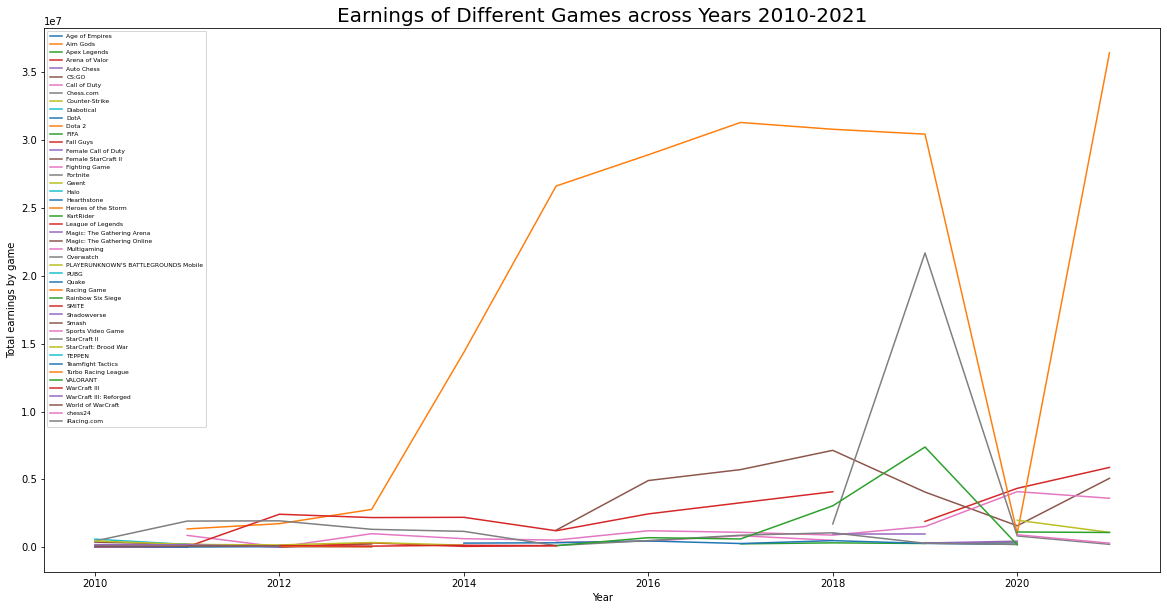

In [132]:
data = {}
plt.figure(figsize = (20,10))
plt.title("Earnings of Different Games across Years 2010-2021")
plt.xlabel("Year")
plt.ylabel("Total earnings by game")
for game in game_titles:
    r = df1[['Year','Game','Total_Year']].groupby('Game').get_group(game)
    data[game] = years_table.merge(r, how = 'left', on = ['Year'])
    plt.plot(data[game]['Year'], data[game]['Total_Year'], label = game)
    plt.legend(loc = "upper left", prop={'size': 6})

Ok This might be a lot of information, but we can clearly see how much the competitve scene has increased throughout the past couple years from 2010 all the way to 2019.

### What caused the drop off during 2020? 

Initially, this outlier of datapoints may make our data look bad. Why did the competitive earnings decrease for almost the entire list of games, other than League of Legends and Call of Duty? 

This is where we must do research and find out why this may have occured and broke this trend. 
Obviously, games come and go in terms of popularity. Games like Dota 2, that were popular when it first came out became less popular once similar games came out, like League of Legends. 
Both of these games are of the same genre, "MOBA" games, which means that they will be competiting for viewership. However, it is unlikely for every game to fall off the charts that quickly.

Towards the end of 2019, the world was hit with an epidemic, COVID-19. Because of this, a lot of eSports competitions were put on hold. Having no  competition furthermore means that there will be no earnings in those years.
You can read more about the statistics at this link.
https://www.statista.com/topics/8316/covid-19-impact-esports-market/#dossierKeyfigures

Therefore, lets fix this as the years 2020 and beyond created outliers that skewed our data. 

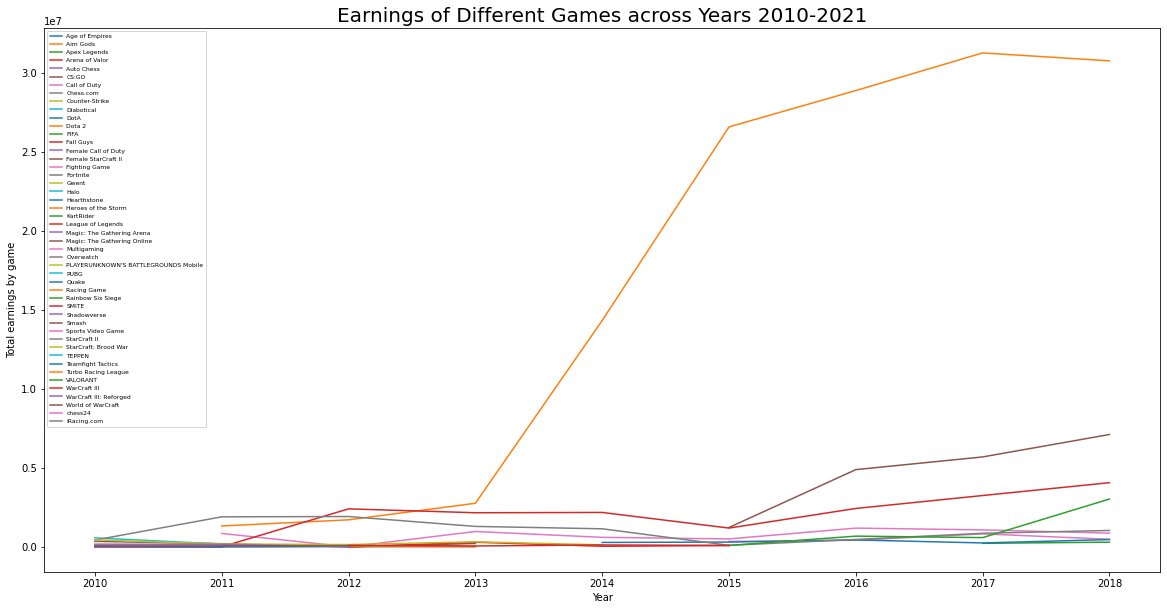

In [133]:
years2 = np.arange(2010,2019)
years_table2 = pd.DataFrame(columns = ['Year'], data = years2)
#Making a copy here. May be a good idea once in a while to do so if you are consistently working with one dataframe.
#On the notebook, if you rerun the same codeblock after modifying the dataframe, you make run into some errors so you 
#would have to run everything again.
df2 = df.copy()
df2 = df2[['Year', 'Game', 'Total_Year']]
df2 = df2.groupby(['Year', 'Game']).sum()
df2.reset_index(inplace= True)

#Lets add the data one by one again
data1 = {}
plt.figure(figsize = (20,10))
plt.title("Earnings of Different Games across Years 2010-2021")
plt.xlabel("Year")
plt.ylabel("Total earnings by game")
for game in game_titles:
    r = df1[['Year','Game','Total_Year']].groupby('Game').get_group(game)
    data1[game] = years_table2.merge(r, how = 'left', on = ['Year'])
    plt.plot(data1[game]['Year'], data1[game]['Total_Year'], label = game)
    plt.legend(loc = "upper left", prop={'size': 6})

Now we can see the steady increases in earnings in games throughout the years. That's great, but lets visualize this a different way. 
We want to see this steady increase over time therefore lets try a bar graph to visualize this. Instead of separating each game, lets find the mean of earnings of everyteam for a year. 
This way, we compare the mean earnings of games from years 2010 all the way to year 2019. 

<BarContainer object of 12 artists>

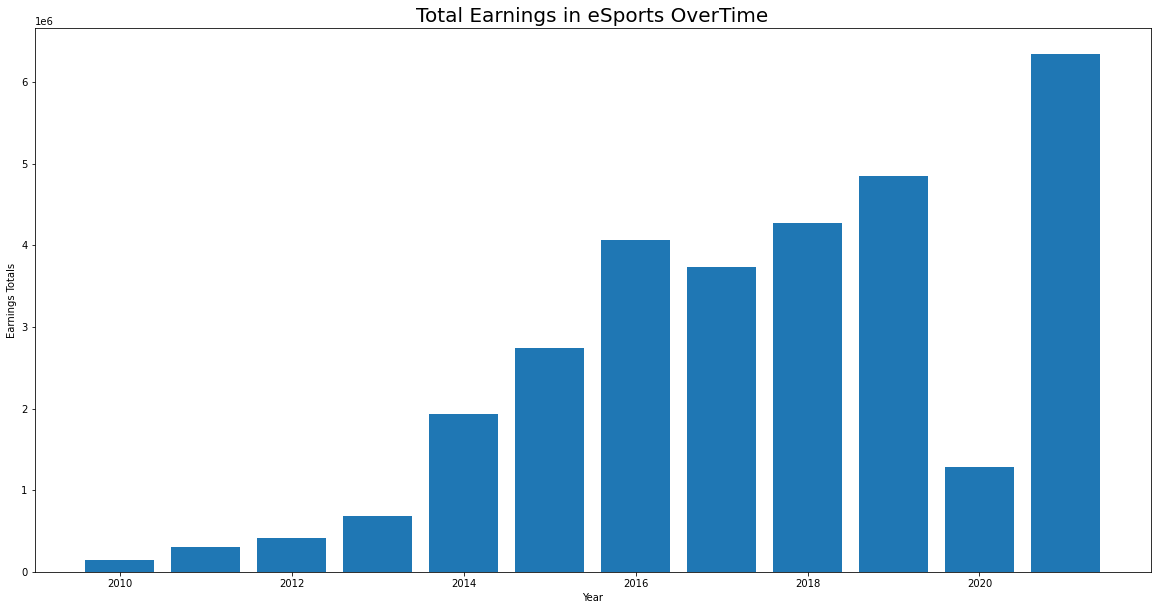

In [134]:
plt.figure(figsize = (20,10))
plt.title("Total Earnings in eSports OverTime")
plt.xlabel("Year")
plt.ylabel("Earnings Totals")

#Lets calculate the means of this dataframe. Group by the year and now grab the total amount and then calculate
#The mean across all the different games that year
means_by_year = df2[['Year','Total_Year']].groupby('Year').mean()
#This is the code to graph
plt.bar(means_by_year.index, means_by_year['Total_Year'])

It is now much much clearer to us that the competitive industry has been slowly growing throughout the past couple of years. We previously removed the year 2020 from our data visualization as you can see how far it dipped in comparison to 2019. However, since the gaming industry adjusted to post-covid, you can see how eSports earnings in tournaments skyrocketed. 

## Linear Regression

Lets draw some lines to see the relationship between our variables. 
In statistics, linear regression is a linear approach for modelling the relationship between a scalar response and one or more explanatory variables.

Here lets take a look at the correlation between the variables Year as well as Earnings for that year. Previously, we looked at all the games together. Now it may be a better idea to look at each games individually and pick apart the earnings. We will only look at the top 10 most earned games as going through all of the games listed in our dataset would be too much. 


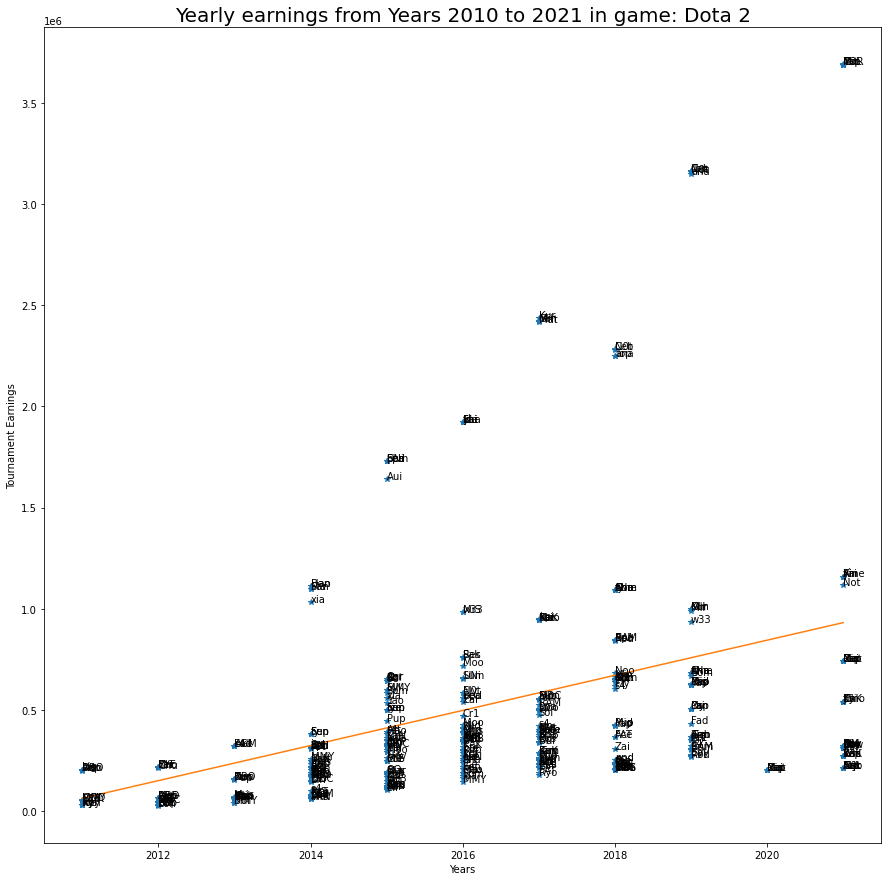

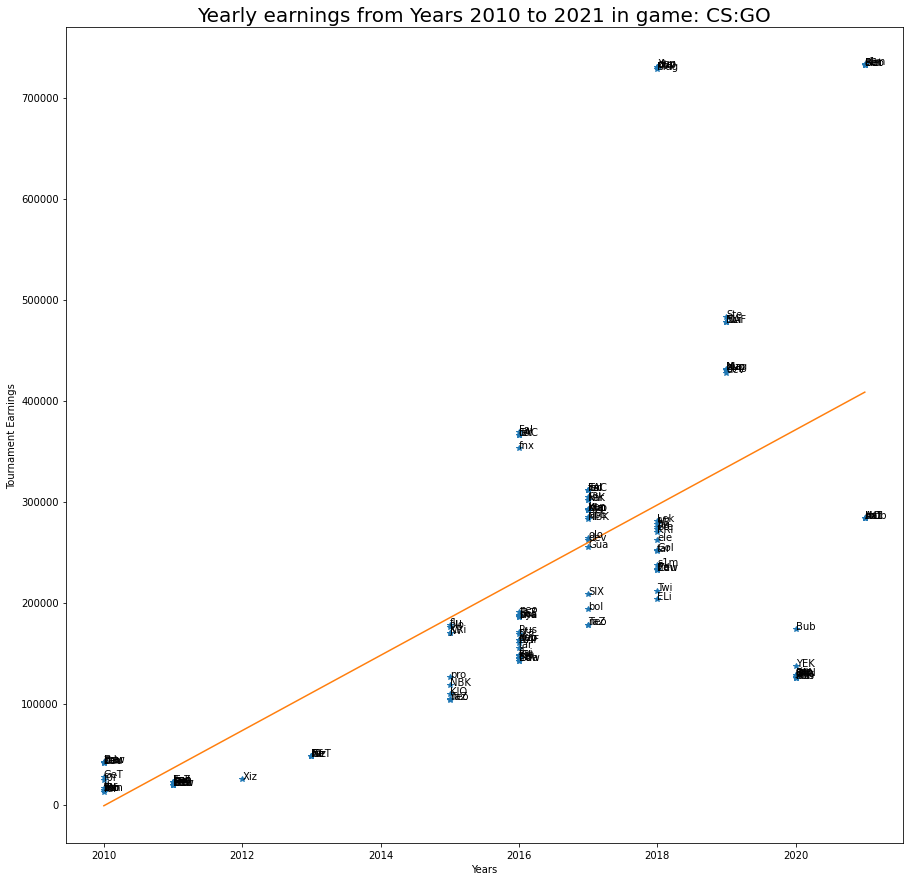

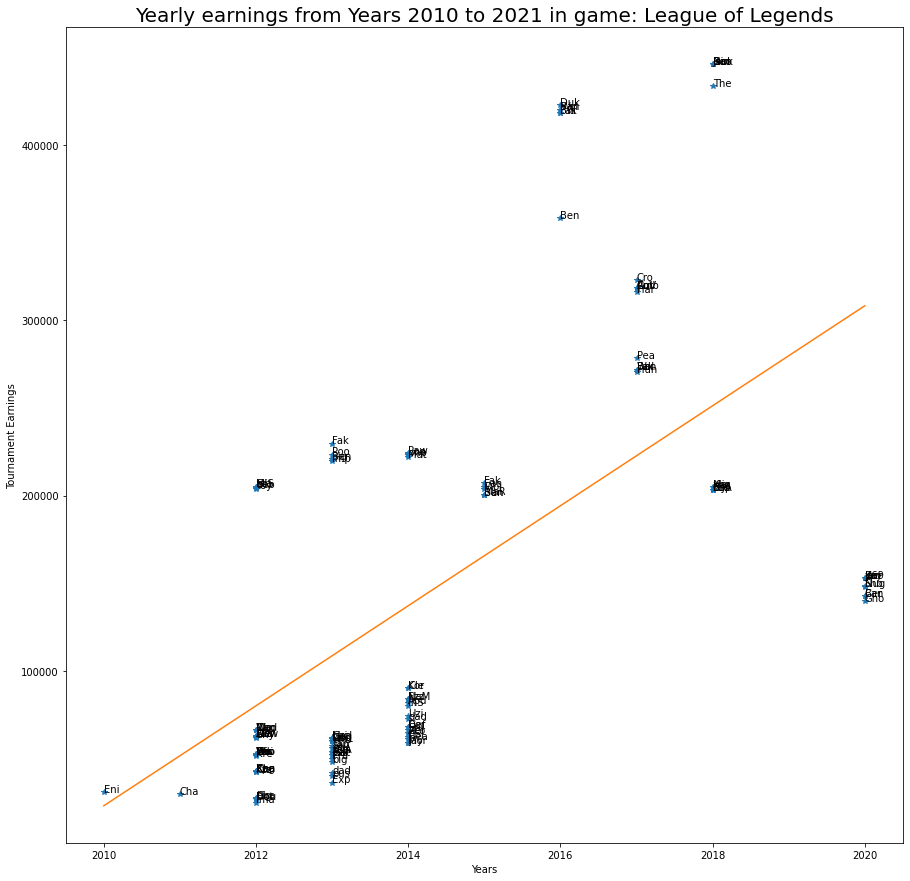

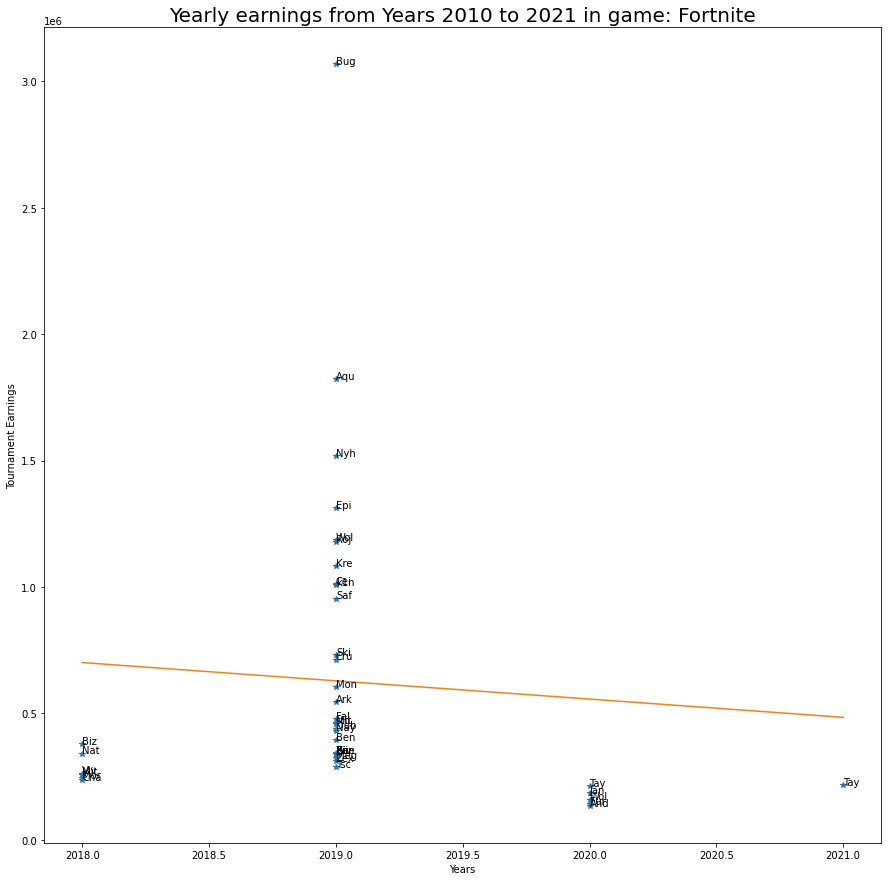

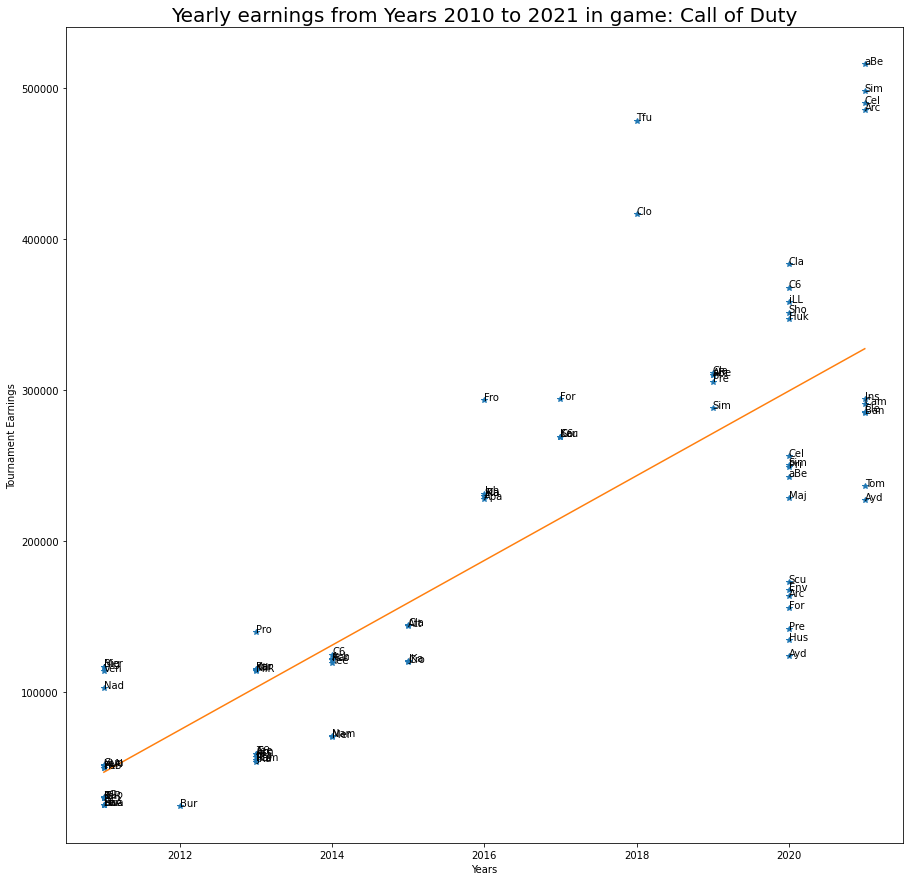

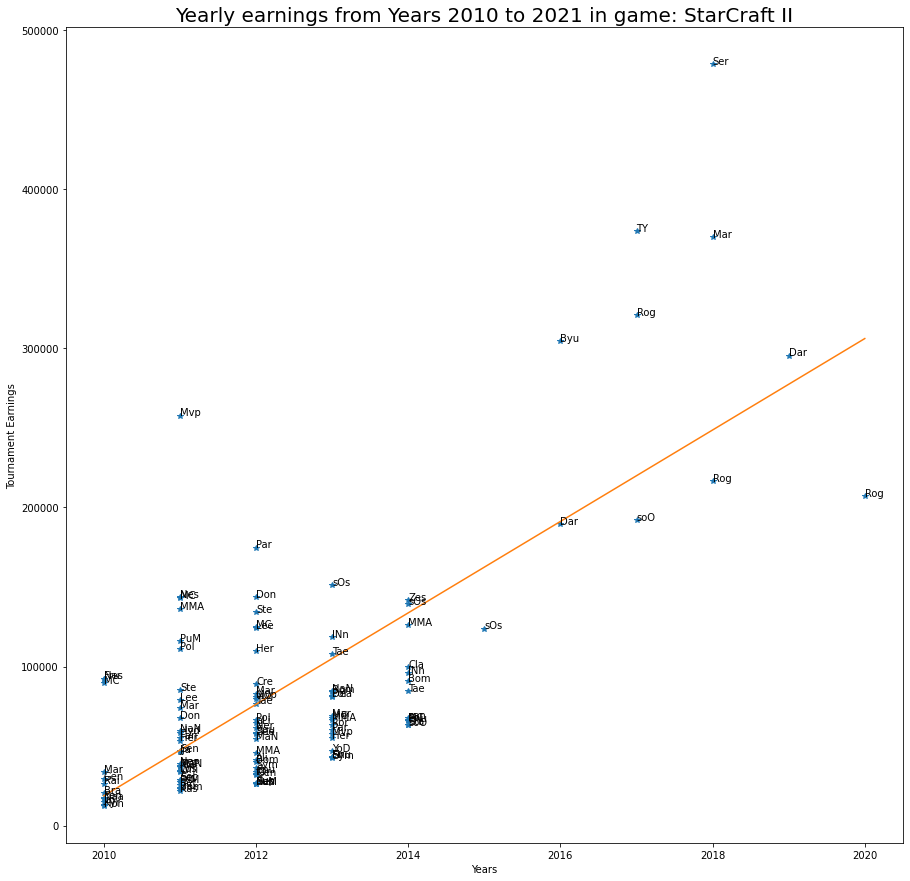

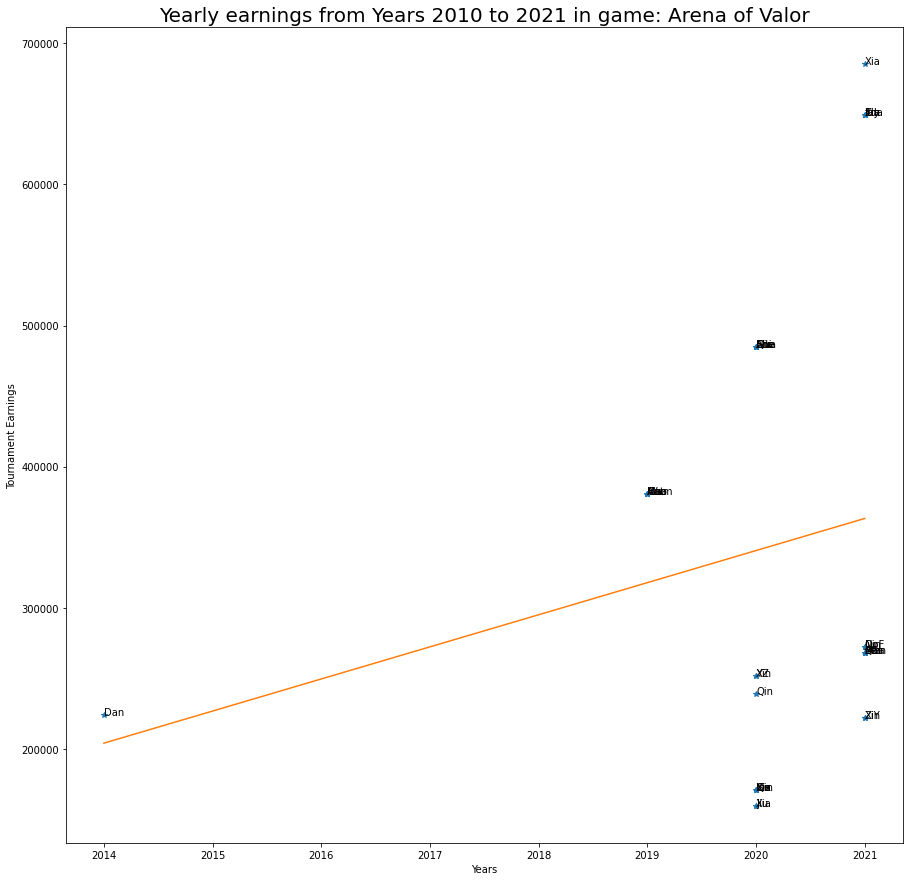

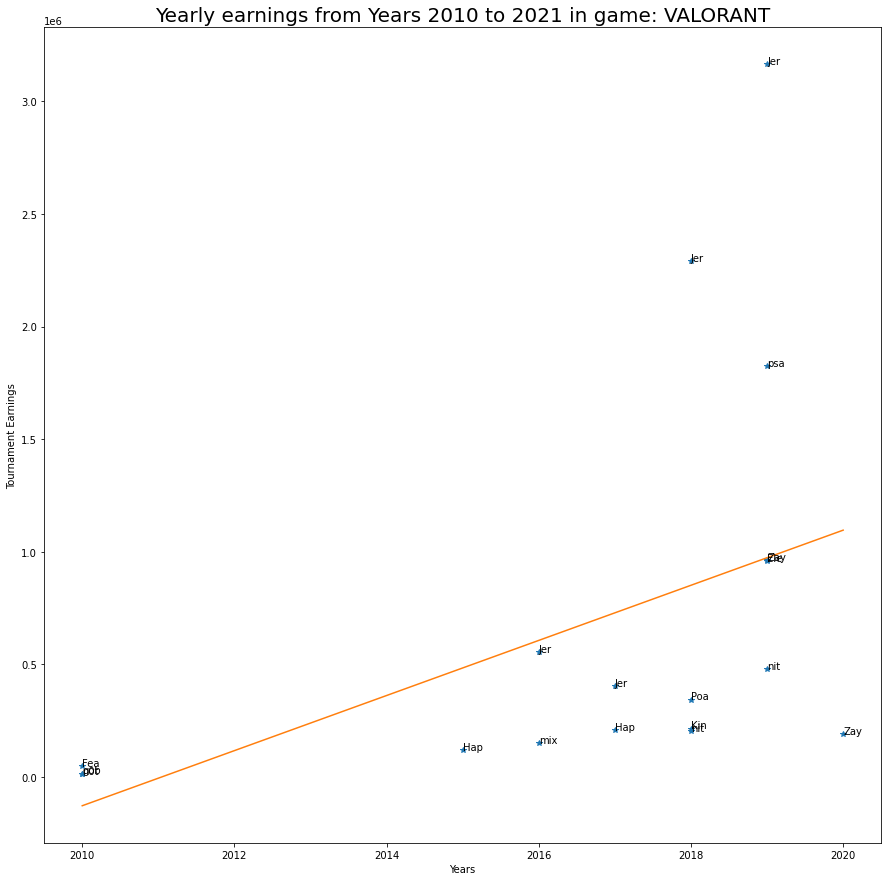

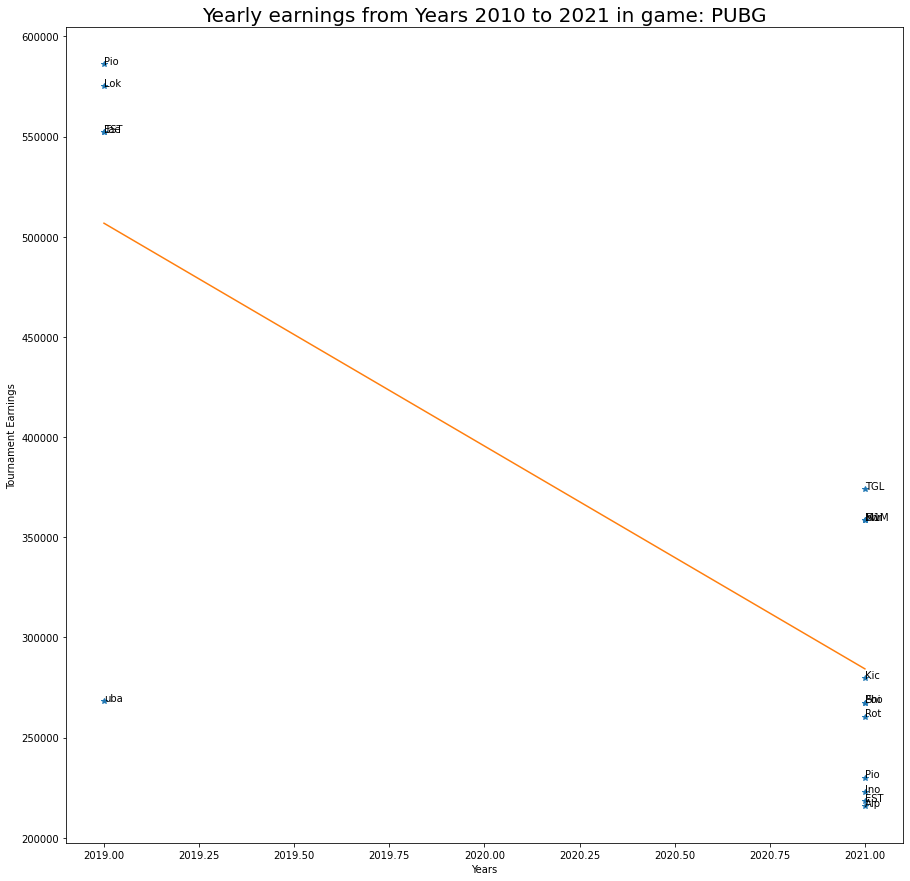

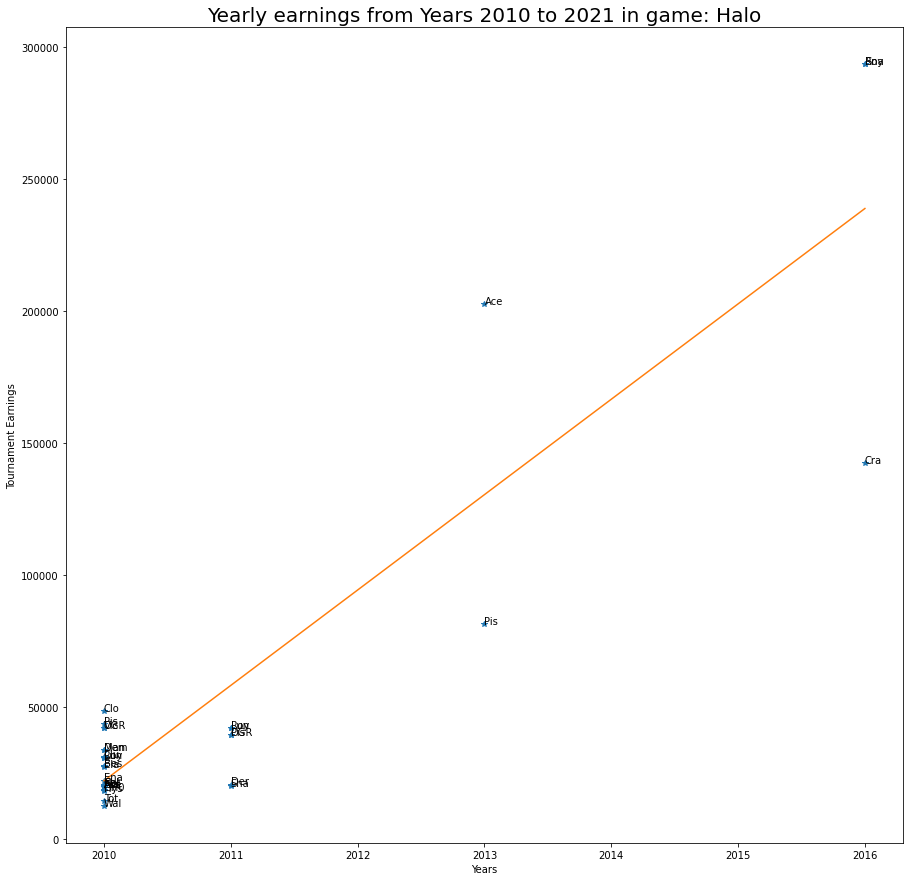

In [135]:
regTable = df[['Year', 'IGN','Game', 'Total_Year']]
games = ['Dota 2', 'CS:GO', 'League of Legends', 'Fortnite', 'Call of Duty','StarCraft II', 'Arena of Valor', 'VALORANT','PUBG','Halo']
#So here we run through every game in the game title. The goal is to calculate the means for each year 
#And plot them. X axis will be our years and Y Axis will be our earnings values. 
for game in games:
    temp = regTable[game == regTable['Game']]
    #print(temp)
    means = (temp.groupby('IGN'))['Total_Year'].mean().to_frame()
    
    xaxis = temp['Year'].values
    yaxis = temp['Total_Year'].values
    
    #Finding the line of best fit 
    
    m,b = np.polyfit(x = xaxis, y = yaxis, deg = 1)
    plt.figure(figsize = (15,15))
    plt.plot(xaxis, yaxis, "*")
    plt.plot(xaxis, m*xaxis+b)
    
    plt.title("Yearly earnings from Years 2010 to 2021 in game: " + game)
    plt.xlabel("Years")
    plt.ylabel('Tournament Earnings')
    for index, name in enumerate(temp['IGN']):
        name = name[0:3]
        plt.annotate(name, (xaxis[index],yaxis[index]))
        
    plt.show()

Now we have 10 different plots for all 10 of our games. We can see based on our linear regression model that all games show positive trends indicating that the tournament earnings have generally increased in a very large manner.

#### Couple of things to take note while looking at these charts

As stated before, games come and go out of popularity. Looking at our charts, some of these games (such as PUBG) don't have data values for years before 2019. This makes sense as the game is newly released and therefore had no competitive scene before then. Games like Halo, on the other hand, had less and less competitive players that made the earnings "leaderboard" as time went along. However, despite this, you can still see that generally speaking, tournament winners from 2016 have much larger earnings than compared to 2010 for Halo itself. 

League of Legends, Dota 2, and CS:GO are great indicators that earnings of gone up throughout time as they consistenly have a large number of players/teams, which helps to show the increase in numbers throughout the past decade. The only outlier here is Fortnite, which has seen a slow decrease from 2018. However, lets look at the YAxis. The numbers it starts off with is 500,000, about as great as tournament earnings from Call of Duty in 2021. Because Fortnite started so high, it mostly stayed level in terms of earnings in the competitive field, and slowly decreased a bit in 2021. Despite this, there are only three years as data points therefore we can't say that the weak negative relationship tells much. 

## Machine Learning

In [141]:
regTable = df[['Year','Player Name', 'IGN', 'Total_Year']]

top_2021 = regTable[regTable['Year'] == 2021]

top_10_2021_name = top_2021[:10]

top_10_2021_name

,Year,Player Name,IGN,Total_Year
1100,2021,Miroslaw Kolpakov,Mira,3689072.43
1101,2021,Yaroslav Naydenov,Miposhka,3687993.33
1102,2021,Alexander Khertek,TORONTOTOKYO,3687993.33
1103,2021,Magomed Halilov,CoLLapse,3687993.33
1104,2021,Illya Mulyarchuk,Yatoro,3687993.33
1105,2021,"Wang, Chunyu",Ame,1158680.00
1106,2021,Zhang Yiping,y`,1158680.00
1107,2021,Zhang Ruida,Faith_bian,1158680.00
1108,2021,Zhao Zixing,XinQ,1158680.00
1109,2021,"Cheng, Jin Xiang",NothingToSay,1118780.00


In [170]:
cols = ["Year", "IGN", "Player Name", "Total Earnings"]

url = "https://www.esportsearnings.com/history/2021/top_players"
page = session.get(url)
root = BeautifulSoup(page.content)
root.prettify()

table = root.find("table")
rows = table.findAll('tr')

players = rows[1:11]

year = []
ign = []
player_name = []
total_year = []

for player in players:
    infos = player.findAll('td')
    links = infos[1].findAll('a')

    url2 = "https://www.esportsearnings.com/" + links[1].get('href')
    page = session.get(url2)
    root = BeautifulSoup(page.content)
    table2 = root.findAll("table")
    rows = table2[0].findAll('tr')
    for row in rows[2:]:
        rows2 = row.findAll('td')
        year.append(rows2[0].text.strip())
        ign.append(infos[1].text.strip())
        player_name.append(infos[2].text.strip())
        total_year.append(rows2[1].text.strip())
        
top_10_2021 = pd.DataFrame(columns = cols)
top_10_2021['Year'] = year
top_10_2021['IGN'] = ign
top_10_2021['Player Name'] = player_name
top_10_2021['Total Earnings'] = total_year
        

top_10_2021['Total Earnings'] = top_10_2021['Total Earnings'].str.replace("$","")
top_10_2021['Total Earnings'] = top_10_2021['Total Earnings'].str.replace(",","")
top_10_2021['Total Earnings'] = top_10_2021['Total Earnings'].astype(float)

top_10_2021

C:\Users\Jordan\AppData\Local\Temp/ipykernel_14008/173548258.py:41: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  top_10_2021['Total Earnings'] = top_10_2021['Total Earnings'].str.replace("$","")


,Year,IGN,Player Name,Total Earnings
0,2021,Mira,Miroslaw Kolpakov,3689072.43
1,2020,Mira,Miroslaw Kolpakov,1000.00
2,2019,Mira,Miroslaw Kolpakov,38.62
3,2021,Miposhka,Yaroslav Naydenov,3687993.33
4,2020,Miposhka,Yaroslav Naydenov,20400.00
5,2019,Miposhka,Yaroslav Naydenov,14120.00
6,2018,Miposhka,Yaroslav Naydenov,18036.33
7,2017,Miposhka,Yaroslav Naydenov,165706.49
8,2016,Miposhka,Yaroslav Naydenov,24979.83
9,2015,Miposhka,Yaroslav Naydenov,817.03


Looking at Players with more than or have 5 years of earnings. 

In [171]:
miposhka_df = top_10_2021[top_10_2021['IGN'].str.contains('Miposhka')]

ame_df = top_10_2021[top_10_2021['IGN'].str.contains('Ame')]

faith_bian_df = top_10_2021[top_10_2021['IGN'].str.contains('Faith_bian')]

xinq_df = top_10_2021[top_10_2021['IGN'].str.contains('XinQ')]

y_df = top_10_2021[top_10_2021['IGN'].str.contains('y`')]

,Year,IGN,Player Name,Total Earnings
3,2021,Miposhka,Yaroslav Naydenov,3687993.33
4,2020,Miposhka,Yaroslav Naydenov,20400.00
5,2019,Miposhka,Yaroslav Naydenov,14120.00
6,2018,Miposhka,Yaroslav Naydenov,18036.33
7,2017,Miposhka,Yaroslav Naydenov,165706.49
8,2016,Miposhka,Yaroslav Naydenov,24979.83
9,2015,Miposhka,Yaroslav Naydenov,817.03


Ordinary Least Squares (OLS)
Coefficients:  [401154.2713253]
Intercept:  [-8.08899353e+08]
Mean squared error: 139125719305.15
Coefficient of determination: -29.06


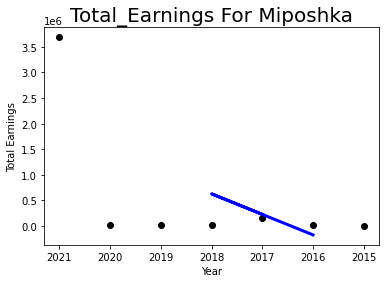

Ordinary Least Squares (OLS)
Coefficients:  [198572.83066667]
Intercept:  [-4.00007668e+08]
Mean squared error: 426929602445.36
Coefficient of determination: -3.62


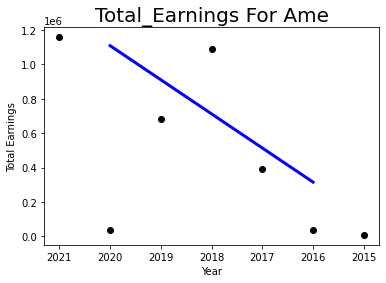

Ordinary Least Squares (OLS)
Coefficients:  [108534.91408602]
Intercept:  [-2.18733303e+08]
Mean squared error: 1188834367460.26
Coefficient of determination: -0.51


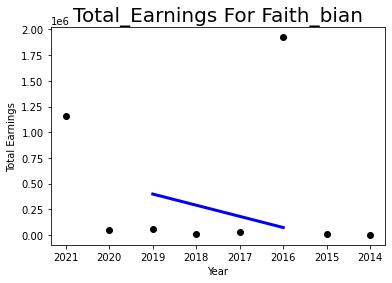

Ordinary Least Squares (OLS)
Coefficients:  [17276.941]
Intercept:  [-34813382.07399999]
Mean squared error: 372021671580.43
Coefficient of determination: -0.35


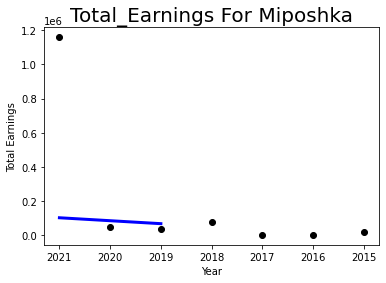

Ordinary Least Squares (OLS)
Coefficients:  [-89595.60947368]
Intercept:  [1.81148053e+08]
Mean squared error: 549097834199.89
Coefficient of determination: -0.88


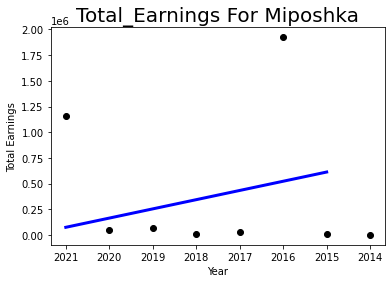

In [267]:
def runML(X, Y, xlabel, ylabel, title):
    # split the data into training/testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

    # create linear regression object
    model = linear_model.LinearRegression()

    # train the model using the training sets
    model.fit(X_train, Y_train)

    # make predictions using the testing set
    Y_pred = model.predict(X_test)

    print('Ordinary Least Squares (OLS)')
    print('Coefficients: ', model.coef_[0])
    print('Intercept: ', model.intercept_)
    print('Mean squared error: %.2f'
          % mean_squared_error(Y_test, Y_pred))
    print('Coefficient of determination: %.2f'
          % r2_score(Y_test, Y_pred))

    plt.scatter(X.to_numpy()[:,0], Y.to_numpy()[:,0],  color='black')
    plt.plot(X_test.to_numpy()[:,0], Y_pred, color='blue', linewidth=3)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

X = miposhka_df[['Year']]
Y = miposhka_df[['Total Earnings']]

runML(X, Y, 'Year', 'Total Earnings', 'Total_Earnings For Miposhka')

X = ame_df[['Year']]
Y = ame_df[['Total Earnings']]

runML(X, Y, 'Year', 'Total Earnings', 'Total_Earnings For Ame')

X = faith_bian_df[['Year']]
Y = faith_bian_df[['Total Earnings']]

runML(X, Y, 'Year', 'Total Earnings', 'Total_Earnings For Faith_bian')

X = xinq_df[['Year']]
Y = xinq_df[['Total Earnings']]

runML(X, Y, 'Year', 'Total Earnings', 'Total_Earnings For Miposhka')

X = y_df[['Year']]
Y = y_df[['Total Earnings']]

runML(X, Y, 'Year', 'Total Earnings', 'Total_Earnings For Miposhka')

## Resources

To learn more about the topics we've covered, check the following links:

 - [Intro to Python Data Scraping](https://realpython.com/python-web-scraping-practical-introduction/)
 - [What is Data Scraping](https://www.targetinternet.com/what-is-data-scraping-and-how-can-you-use-it/)
 - [Explanatory Data Analysis](https://towardsdatascience.com/exploratory-data-analysis-eda-a-practical-guide-and-template-for-structured-data-abfbf3ee3bd9)
 - [Bunch of Links to Machine Learning Articles](https://medium.com/machine-learning-in-practice/over-200-of-the-best-machine-learning-nlp-and-python-tutorials-2018-edition-dd8cf53cb7dc)